In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [ ]:
%cd "/content/drive/MyDrive/Kaggle"

/content/drive/MyDrive/Kaggle


In [ ]:
! kaggle datasets download -d puneet6060/intel-image-classification

100% 346M/346M [00:09<00:00, 39.0MB/s]
100% 346M/346M [00:09<00:00, 37.3MB/s]


In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification --unzip --force


 99% 343M/346M [00:08<00:00, 44.8MB/s]
100% 346M/346M [00:09<00:00, 40.2MB/s]


In [ ]:
train_path = '/content/drive/MyDrive/Kaggle/seg_train' + "/seg_train"
test_path = '/content/drive/MyDrive/Kaggle/seg_test' + "/seg_test/"
pred_path = '/content/drive/MyDrive/Kaggle/seg_pred' + '/seg_pred'

In [ ]:
train_path , test_path , pred_path

('/content/drive/MyDrive/Kaggle/seg_train/seg_train',
 '/content/drive/MyDrive/Kaggle/seg_test/seg_test/',
 '/content/drive/MyDrive/Kaggle/seg_pred/seg_pred')

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

In [ ]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

In [ ]:
size_images = 150
batch_size = 32

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(size_images, size_images),  # Resize images to this size
    batch_size = batch_size,        # Number of images in each batch
    class_mode ='categorical'       # Mode for class labels (categorical for one-hot encoding)
)

Found 14034 images belonging to 6 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
# Create a generator for testing data
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(size_images, size_images),
    batch_size = batch_size,
    class_mode='categorical')

Found 3000 images belonging to 6 classes.


In [ ]:
def Show_Images(target_gen):
    # Get a batch of images and labels
    batch_images, batch_labels = next(target_gen)

    # Get class labels
    class_labels = list(target_gen.class_indices.keys())

    # Display images with labels
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),36))):
        plt.subplot(6, 6, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])  # Display the class label
        plt.axis('off')
    plt.show()

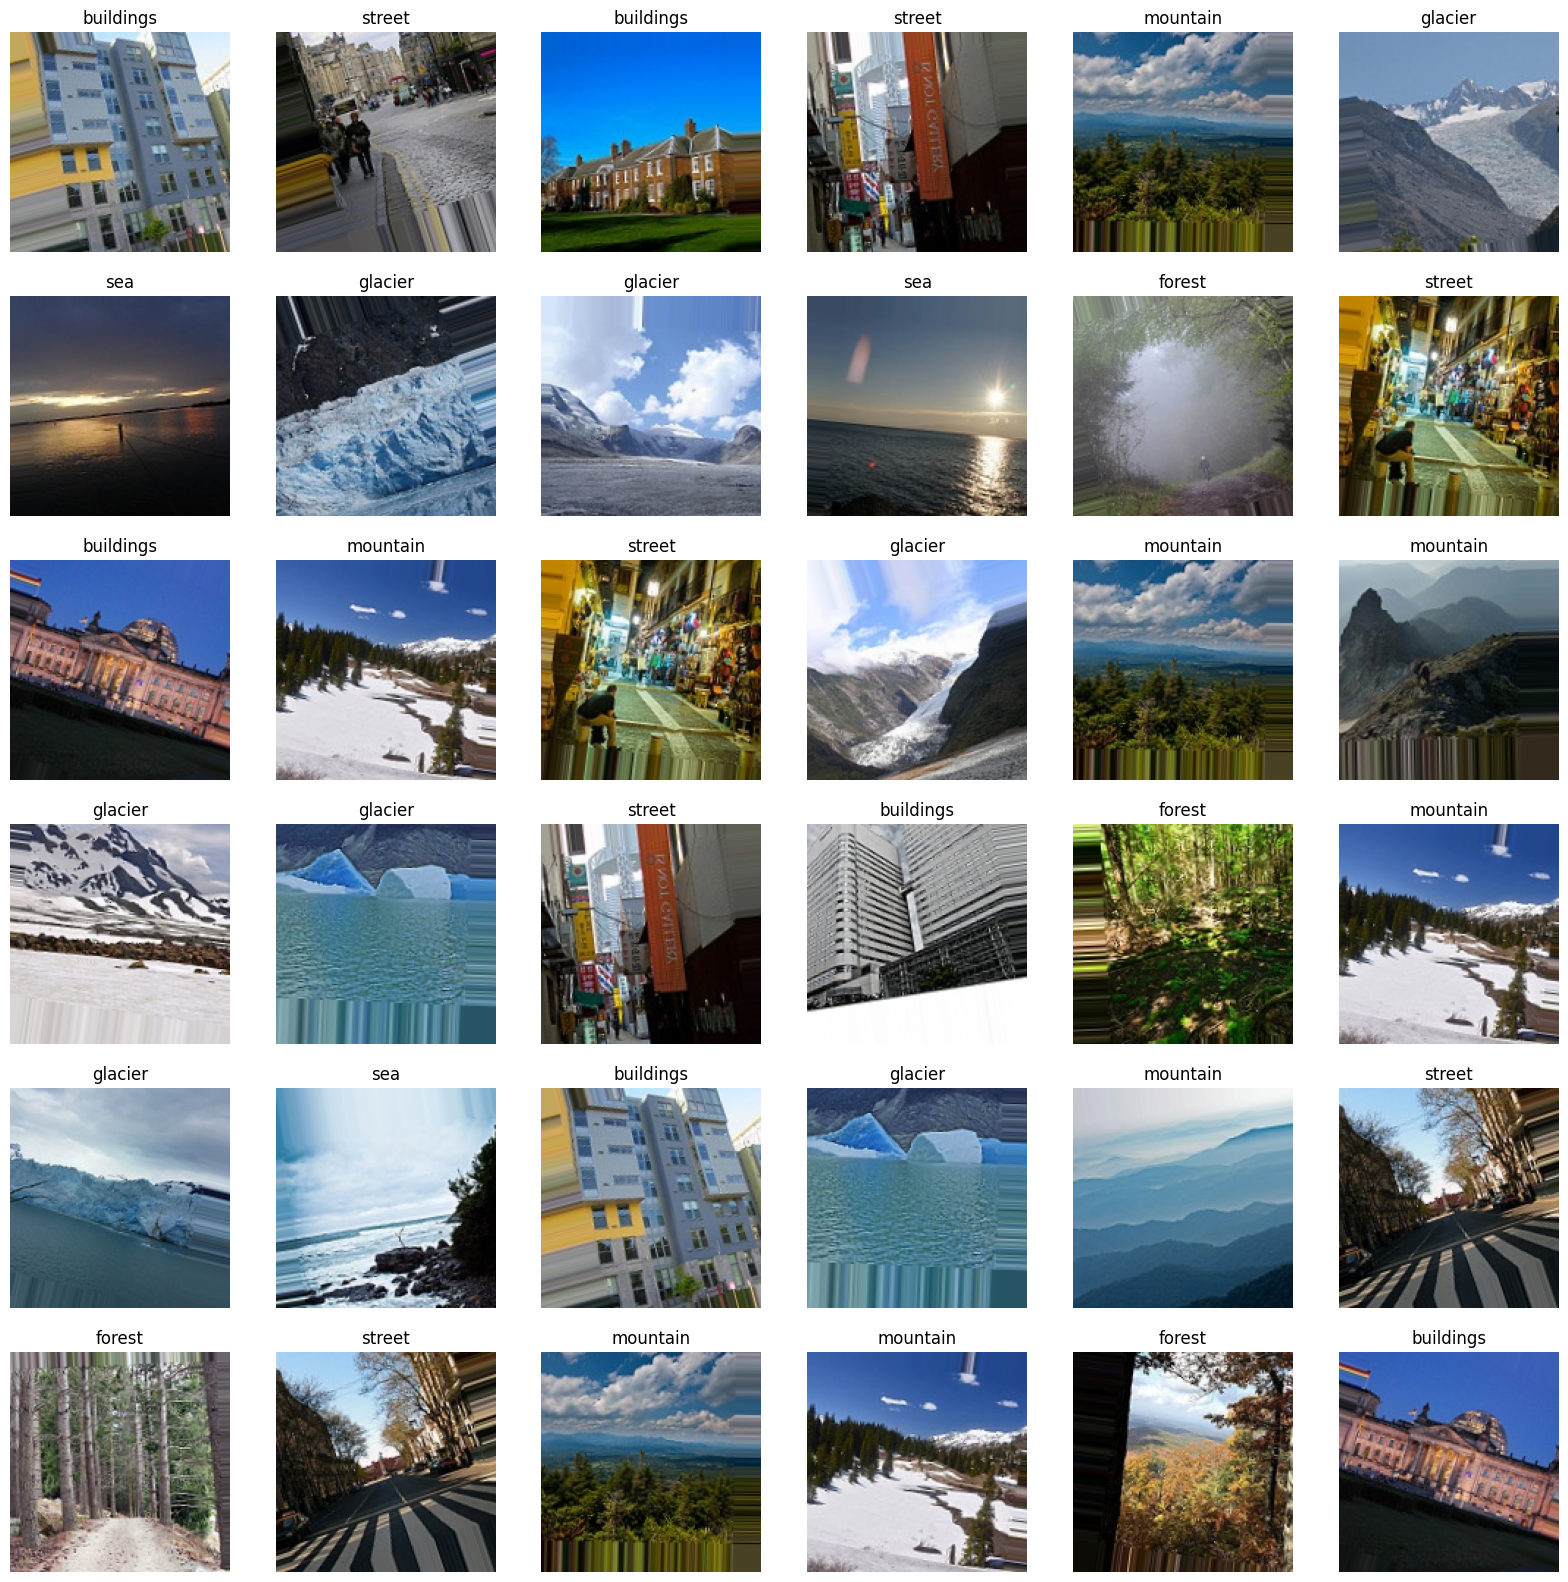

In [ ]:
Show_Images(train_generator)

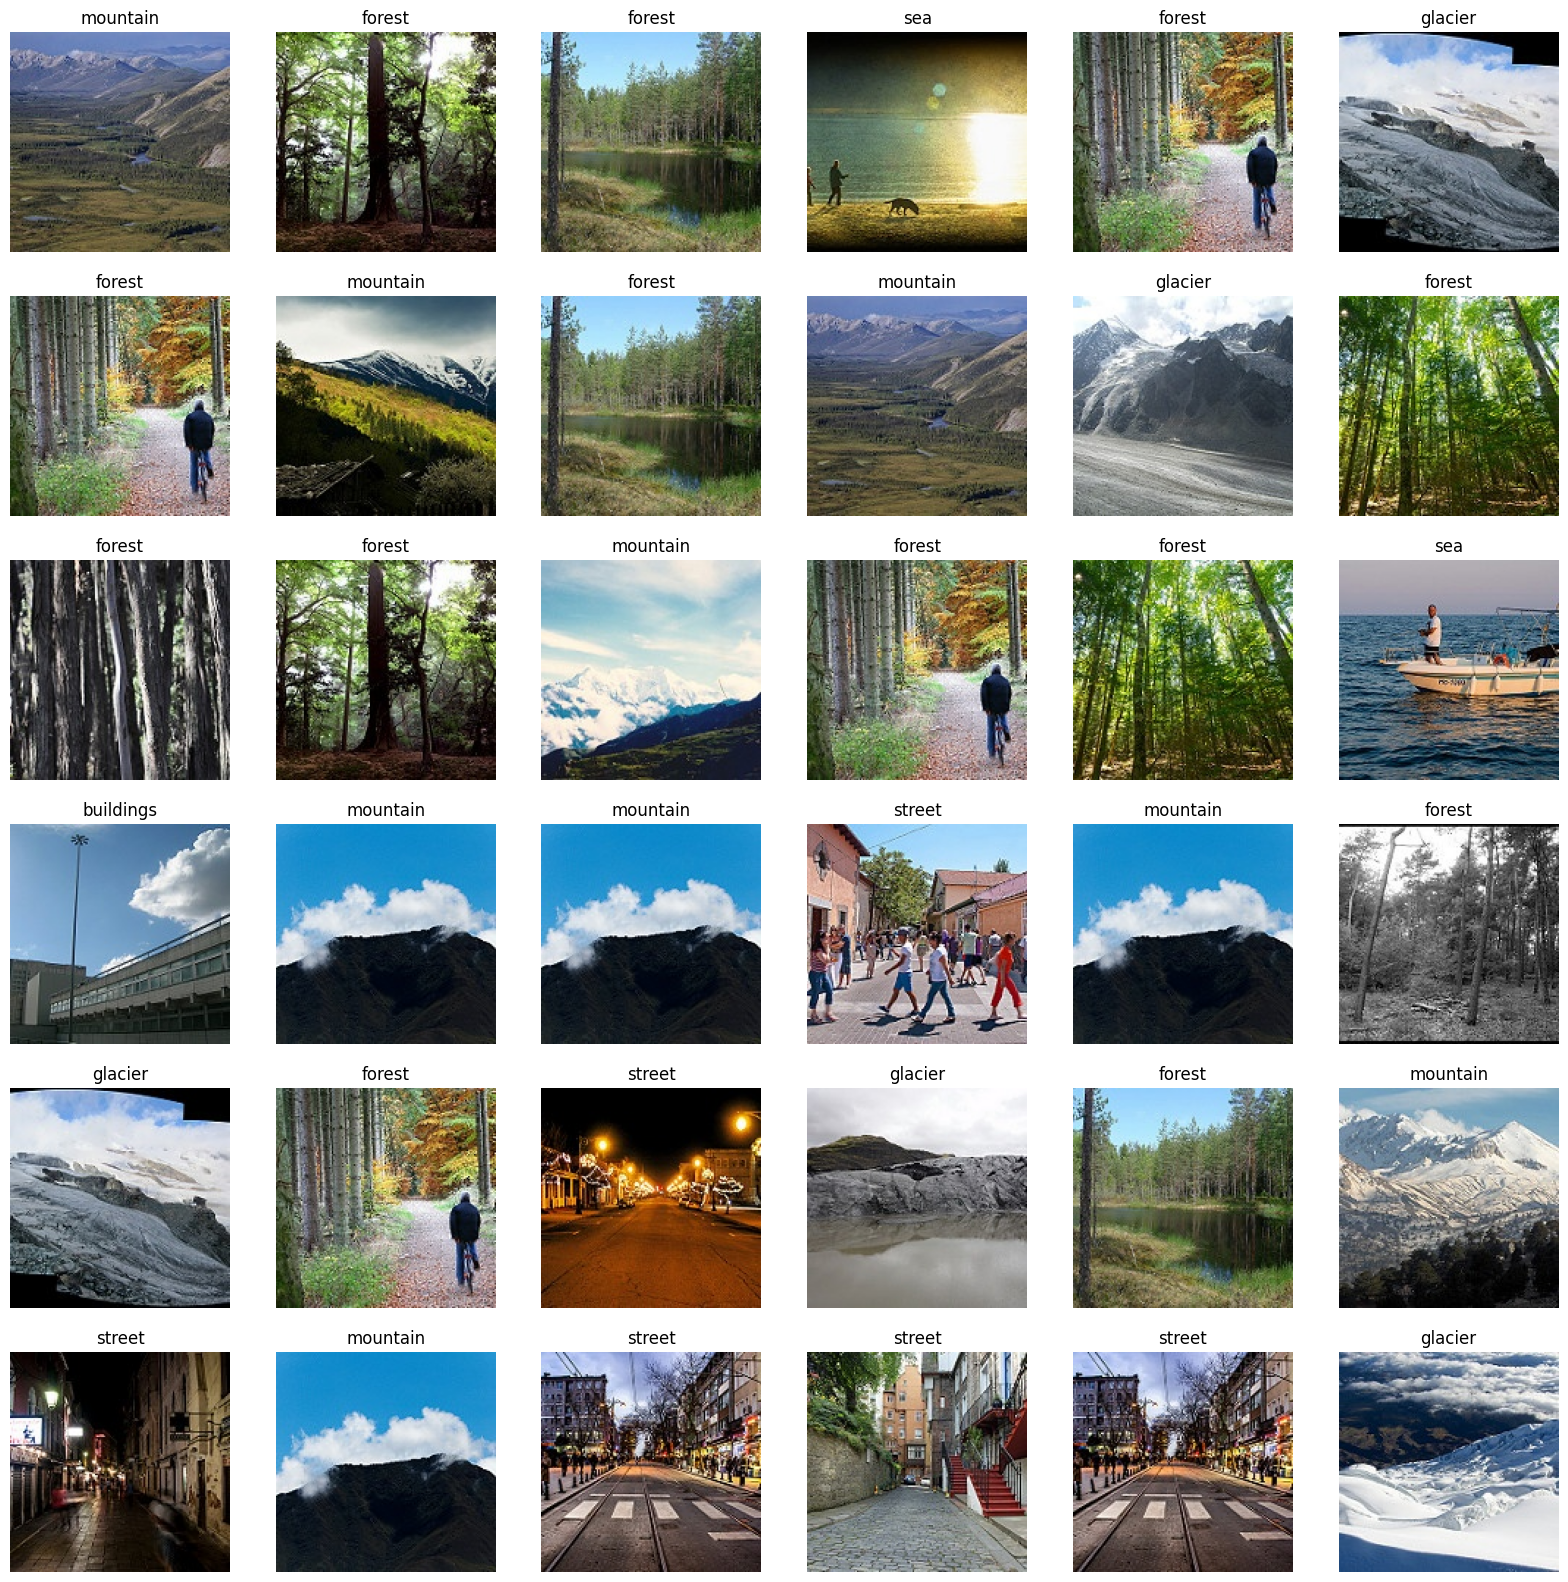

In [ ]:
Show_Images(test_generator)


In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [ ]:
# Configure the learning rate reduction callback
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   # Metric to monitor for changes (usually validation accuracy)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)

In [ ]:
from keras.applications import VGG16


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(size_images, size_images, 3))


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model = tf.keras.models.Sequential([
    base_model,

    layers.Flatten(),

    layers.Dense(256,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6,activation='softmax'),
])

In [ ]:
# Define the parameters for the exponential decay schedule
initial_learning_rate = 0.1     # Initial learning rate
decay_steps = 1000              # Number of steps before decaying the learning rate
decay_rate = 0.5                # Rate at which the learning rate decays
staircase = True                # Whether to use staircase decay (integer division of step by decay_steps)

# Create the exponential decay schedule
def lr_schedule(epoch, lr):
    if staircase:
        return lr * decay_rate ** (epoch // decay_steps)
    else:
        return lr * decay_rate ** (epoch / decay_steps)

In [ ]:
from keras.callbacks import LearningRateScheduler

lr_callback = LearningRateScheduler(lr_schedule)
callback=[early_stopping , learning_rate_reduce , lr_callback]

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(lr=lr_callback),
             loss="categorical_crossentropy",
              metrics=['accuracy']
             )

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[callback]
)

Epoch 1/20
438/438 [==============================] - ETA: 0s - loss: 0.7562 - accuracy: 0.7243

438/438 [==============================] - 4762s 11s/step - loss: 0.7562 - accuracy: 0.7243 - val_loss: 0.4599 - val_accuracy: 0.8306 - lr: 0.0010
Epoch 2/20
438/438 [==============================] - ETA: 0s - loss: 0.5366 - accuracy: 0.8093